In [1]:
#import necessary modules 
import sklearn
from nn import (nn,io,preprocess)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split #to split the dataset into training, test, and validation

In [2]:
#read in 137 Rap1 motif examples
seqs_rap1 = io.read_text_file("data/rap1-lieb-positives.txt")
#read in negative examples
seqs_neg = io.read_fasta_file("data/yeast-upstream-1k-negative.fa")

In [3]:
#process the negative examples:
seq_length = len(seqs_rap1[0])
processed_seqs_neg = []
for seq in seqs_neg:
    elem = seq[:seq_length]
    processed_seqs_neg.append(elem)
#I truncated the negative sequences to match the length of the positive sequences, which is 17

In [5]:
#balancing the dataset
positive = [1 for i in range(len(seqs_rap1))]
negative = [0 for i in range(len(seqs_neg))]
seqs = seqs_rap1 + processed_seqs_neg
labels = positive + negative
seqs_sampled,labels_sampled = preprocess.sample_seqs(seqs,labels)

Choosing the sampling scheme:

I counted the instances of True and False labels and determined which of these is the majority. I then sampled with replacement from the minority class. I then combined the sequences, adding the minority sampled sequences to the majority sequences. I also shuffled this dataset to maintain a random order. This approach prevents a bias towards the majority dataset, but it could lead to overfitting to the minority. I was having a hard time coming up with a sampling scheme that can remain generalizable while also maintaining a balance between the positive and negative labels to prevent bias. 

In [6]:
#one-hot encoding
encoded_seq = preprocess.one_hot_encode_seqs(seqs_sampled)
#split the data into training and validation
x, x_val, y, y_val = train_test_split (encoded_seq,labels_sampled, test_size=0.2, train_size=0.8 ) #split into 80% training data and 20% testing data

In [7]:
#y_val = np.reshape(y_val, (1,np.shape(y_val)[0]))
#y = np.reshape(y, (1,np.shape(y)[0]))

In [8]:
y_val = np.array(y_val).reshape(-1, 1)
y = np.array(y).reshape(-1, 1)
print(y.shape)
print(y_val.shape)

(4951, 1)
(1238, 1)


In [9]:
# neural network architecture
num = np.shape(x_val)[1]
arch = [{'input_dim': num, 'output_dim': 35, 'activation': 'relu'},
                    {'input_dim': 35, 'output_dim': 1, 'activation': 'sigmoid'}]
                    #{'input_dim': 68, 'output_dim': 1, 'activation': 'sigmoid'}]

In [10]:
batch = np.shape(x)[0]
classifier = nn.NeuralNetwork(arch, lr=0.7, seed=57, batch_size=batch, epochs=50000, loss_function='binary_cross_entropy')
#binary cross entropy is outputting a dA with dim [batch_size,batch_size]

In [11]:
per_epoch_loss_train,per_epoch_loss_val = classifier.fit(x, y, x_val, y_val)

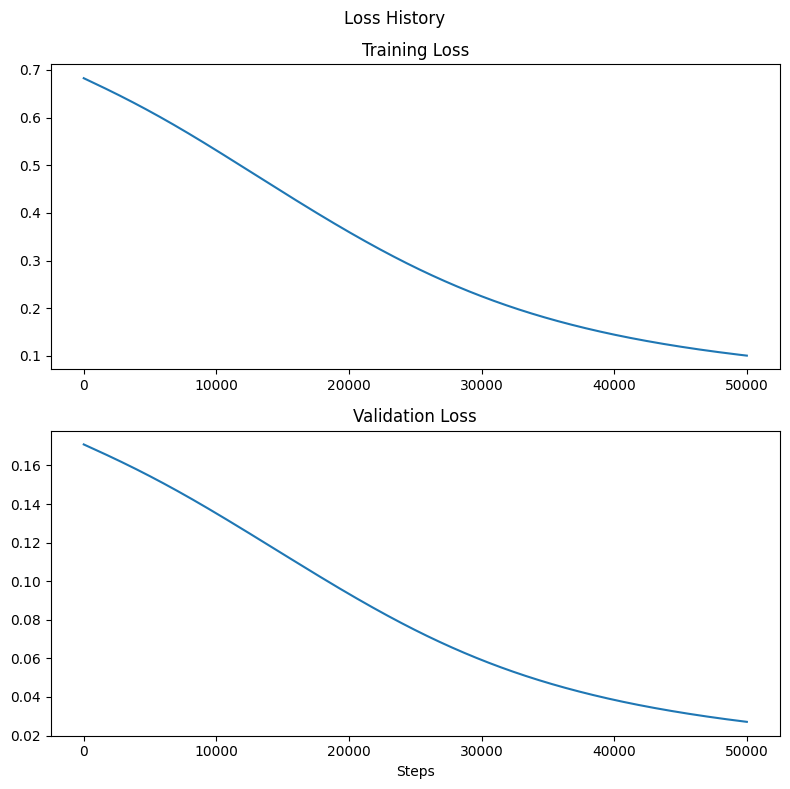

In [12]:
fig, axs = plt.subplots(2, figsize=(8, 8))
fig.suptitle('Loss History')
axs[0].plot(np.arange(len(per_epoch_loss_train)), per_epoch_loss_train)
axs[0].set_title('Training Loss')
axs[1].plot(np.arange(len(per_epoch_loss_val)), per_epoch_loss_val)
axs[1].set_title('Validation Loss')
plt.xlabel('Steps')
fig.tight_layout()
plt.show()

In [13]:
#prediction
y_pred = classifier.predict(x_val)

In [14]:
#accuracy score calculation
from sklearn.metrics import accuracy_score
y_pred_binary = [int(pred > 0.5) for pred in y_pred]
accuracy = accuracy_score(y_val, y_pred_binary)

In [15]:
#reporting the accuracy score
print(accuracy)

0.9862681744749596


Choice of loss function and hyperparameters:

Since the task is a binary classification task (True or False), I chose the binary cross-entropy loss function. As for hyperparameters, I played around with it a bit. I started with 3000 epochs and a learning rate of 0.1. However, this gave me a linear decline in losses. I then tried 10,000 epochs and a 0.7 learning rate. This gave me a decline that looked like the beginning of what the loss curve is supposed to look like. Therefore, I then tried 50,000 epochs (it took 6 minutes to train) and finally got loss curves that decline and then plataeu.